In [1]:
%pip install datasets
%pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from datasets import load_dataset

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Analyzing the content of the columns

In [3]:
ds = load_dataset("Elfsong/Venus_t")

Generating eval split: 100%|██████████| 554/554 [00:00<00:00, 1855.88 examples/s]


In [4]:
ds['train'].features

{'question_id': Value(dtype='int64', id=None),
 'name': Value(dtype='string', id=None),
 'content': Value(dtype='string', id=None),
 'acRate': Value(dtype='float64', id=None),
 'difficulty': Value(dtype='string', id=None),
 'topics': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'runtimeDistribution': Value(dtype='string', id=None),
 'memoryDistribution': Value(dtype='string', id=None),
 'rt_list': [{'code': Value(dtype='string', id=None),
   'runtime': Value(dtype='string', id=None)}],
 'rt_solution_count': Value(dtype='int64', id=None),
 'mm_list': [{'code': Value(dtype='string', id=None),
   'memory': Value(dtype='string', id=None)}],
 'mm_solution_count': Value(dtype='int64', id=None),
 'code_prompt': Value(dtype='string', id=None),
 'test_case_generator': Value(dtype='string', id=None),
 'entry_point': Value(dtype='string', id=None),
 'libraries': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'import_code': Value(dtype='string', id

In [2]:
rt_dist = ds['train'][0]['runtimeDistribution']

NameError: name 'ds' is not defined

In [6]:
import json

In [7]:
rt_dist = json.loads(rt_dist)

In [8]:
test_case = ds['train'][10]['test_case']
# test_case = json.loads(test_case)
test_cases = [json.loads(obj) for obj in test_case.strip().split('\n') if obj]
(test_cases)

[{'input': '8', 'output': '8'},
 {'input': '16', 'output': '16'},
 {'input': '4', 'output': '4'},
 {'input': '7', 'output': 'None'},
 {'input': '9', 'output': 'None'},
 {'input': '16', 'output': '16'},
 {'input': '2', 'output': '2'},
 {'input': '5', 'output': 'None'},
 {'input': '16', 'output': '16'},
 {'input': '2', 'output': '2'},
 {'input': '4', 'output': '4'},
 {'input': '2', 'output': '2'},
 {'input': '4', 'output': '4'},
 {'input': '0', 'output': '0'},
 {'input': '-1', 'output': 'None'},
 {'input': '32', 'output': '32'},
 {'input': '4', 'output': '4'},
 {'input': '0', 'output': '0'},
 {'input': '3', 'output': 'None'},
 {'input': '4', 'output': '4'},
 {'input': '-1', 'output': 'None'},
 {'input': '0', 'output': '0'},
 {'input': '7', 'output': 'None'},
 {'input': '7', 'output': 'None'},
 {'input': '64', 'output': '64'},
 {'input': '7', 'output': 'None'},
 {'input': '1', 'output': '1'},
 {'input': '-1', 'output': 'None'},
 {'input': '0', 'output': '0'},
 {'input': '32', 'output': '3

In [9]:
print(ds['train'][1]['setup_code'])

class Solution:
    def minCut(self, s: str) -> int:
        n = len(s)
        memo_c = [None] * n
        memo_p = [[None] * n for _ in range(n)]
        
        def helper(start, end):
            cut = end
            if start == end or is_p(start, end):
                return 0
            if memo_c[start] is not None:
                return memo_c[start]
            for i in range(start, end + 1):
                if is_p(start, i):
                    cut = min(cut, 1 + helper(i + 1, end))
            
            memo_c[start] = cut
            return cut

        def is_p(start, end):
            if start >= end:
                return True
            if memo_p[start][end] is not None:
                return memo_p[start][end]
            memo_p[start][end] = (s[start] == s[end] and is_p(start + 1, end - 1))
            return memo_p[start][end]

        return helper(0, n - 1)

class TestCaseGenerator:
    def generate(self) -> dict:
        """
        Generates a test case

In [11]:
import matplotlib.pyplot as plt


In [12]:
def plot_distribution(data, name=None, instance=None):
    x = [int(item[0]) for item in data]
    y = [item[1] for item in data]

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', linestyle='-', color='b', label="Distribution")
    
    # If an instance tuple is provided, plot it with a different color
    if instance is not None:
        # Assuming the instance tuple is (runtime, frequency)
        instance_runtime = (instance[0])
        instance_freq = instance[1]
        plt.plot(instance_runtime, instance_freq, marker='o', markersize=10, 
                 linestyle='None', color='r', label="Instance")
    
    plt.xlabel(name)
    plt.ylabel("Frequency")
    plt.title(f"{name} Distribution")
    plt.grid(True)
    plt.legend()
    plt.show()

In [13]:
import pandas as pd

In [14]:

def to_pandas_df(data, name):
    dist_df = pd.DataFrame(data, columns=[name, 'frequency'])

    # Convert the 'Runtime' column from string to integer
    dist_df[name] = dist_df[name].astype(int)

    # Sort the DataFrame by runtime
    dist_df.sort_values(name, inplace=True)

    # Compute the cumulative sum of frequencies
    # dist_df['Cumulative'] = dist_df['frequency'].cumsum()

    return dist_df

In [15]:
dist_df = to_pandas_df(rt_dist['distribution'], 'runtime')

In [16]:
# Picking a random sample to see where it fit on the distribution
row = dist_df.sample(n=1)
row

,runtime,frequency
11,164,0.0444


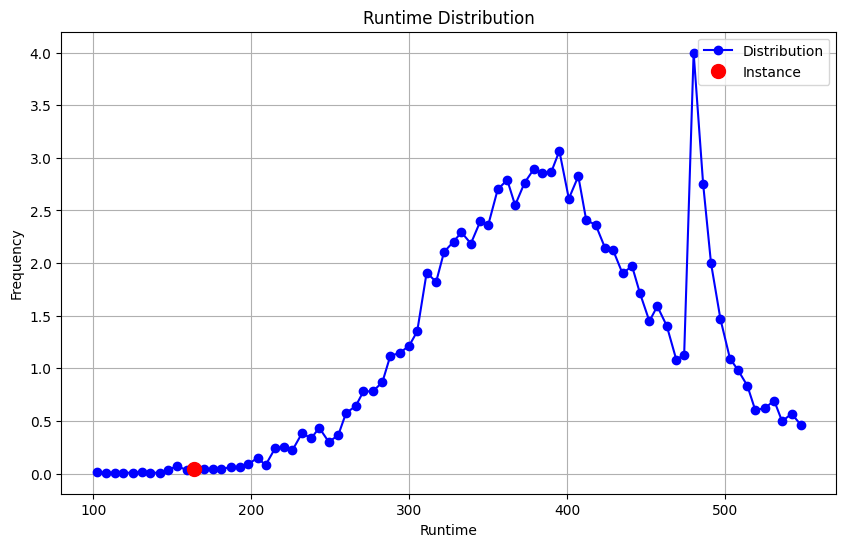

In [17]:
point = (int(row['runtime'].iloc[0]), row['frequency'])
plot_distribution(rt_dist['distribution'], 'Runtime', point)

In [20]:
import numpy as np

In [21]:
# get the nth percentile value of the distribution
def get_nth_percentile(distribution_df, percentile, metric):
    data = np.array(distribution_df[metric])
    return np.percentile(data, percentile)

# check if an instance of the distribution falls into the nth percentile
def is_within_nth_percentile(nth_percentile, instance):
    return instance <= nth_percentile

In [23]:
get_nth_percentile(dist_df, 25, 'runtime')

np.float64(213.5)

# Constructing the dataset

In [30]:
json_dataset = []

# Iterate over the 'train' split
for row in ds["train"]:
    # Runtime solutions
    runtime_efficient_codes = []
    runtime_inefficient_codes = []
    runtime_moderate_codes = []

    # Memory solutions
    memory_efficient_codes = []
    memory_inefficient_codes = []
    memory_moderate_codes = []

    # Get both runtime and memory distribution for the current problem
    runtime_distribution = to_pandas_df(json.loads(row['runtimeDistribution'])['distribution'], 'runtime')
    memory_distribution = to_pandas_df(json.loads(row['memoryDistribution'])['distribution'], 'memory')

    # Obtain the 25th and 75th percentile 
    runtime_twenty_fifth_percentile = get_nth_percentile(runtime_distribution, 25, 'runtime')
    runtime_seventy_fifth_percentile = get_nth_percentile(runtime_distribution, 75, 'runtime')

    for rt_item in row['rt_list']:
        # runtime of the current solution
        runtime = int(rt_item['runtime'])

        if runtime <= runtime_twenty_fifth_percentile:
            runtime_efficient_codes.append(rt_item)
        elif runtime >= runtime_seventy_fifth_percentile:
            runtime_inefficient_codes.append(rt_item)
        else:
            runtime_moderate_codes.append(rt_item)


    # Obtain the 75th percentile for both runtime and memory distribution
    memory_twenty_fifth_percentile = get_nth_percentile(memory_distribution, 25, 'memory')
    memory_seventy_fifth_percentile = get_nth_percentile(memory_distribution, 75, 'memory')

    # Applying the same concept as the above, but for memory efficent code
    for mm_item in row['mm_list']:
        # memory of the current solution
        memory = int(mm_item['memory'])

        if memory <= memory_twenty_fifth_percentile:
            memory_efficient_codes.append(mm_item)
        elif memory >= memory_seventy_fifth_percentile:
            memory_inefficient_codes.append(mm_item)
        else:
            memory_moderate_codes.append(mm_item)

    # Adding the test cases for the problem
    test_cases = [json.loads(obj) for obj in row['test_case'].strip().split('\n') if obj]

    json_data = {
        'question_id': row['question_id'],
        'name': row['name'],
        'prompt': row['content'],
        'difficulty': row['difficulty'],
        'topics': row['topics'],
        'runtime_inefficient_codes': runtime_inefficient_codes,
        'runtime_moderate_codes': runtime_moderate_codes,
        'runtime_efficient_codes': runtime_efficient_codes,
        'memory_inefficient_codes': memory_inefficient_codes,
        'memory_moderate_codes': memory_moderate_codes,
        'memory_efficient_codes': memory_efficient_codes,
        'import_code': row['import_code'],
        'setup_code': row['setup_code'],
        'libraries': row['libraries'],
        'entry_point': row['entry_point'],
        
        'test_cases': test_cases
    }

    json_dataset.append(json_data)


In [31]:
with open('dataset.json', 'w') as json_file:
    json.dump(json_dataset, json_file, indent=4)

HARISH PRE-PROCESSING TC's

In [32]:
df_preview = pd.DataFrame(json_dataset).head()

In [33]:
df_preview.to_json("dataset_preview.json",orient='records',indent=4)

In [58]:
import json
test_cases = []
row = df_preview.iloc[0]
print("Import Code: ",row["import_code"])
print("Setup Code: ",row["setup_code"])
print("Entry Point: ",row["entry_point"])
test_cases = row["test_cases"]


Import Code:  from typing import List
import random
import string
Setup Code:  # Define necessary classes and functions

class Solution:
    def partition(self, s: str) -> List[List[str]]:
        memo = {}

        def palindromes(i):
            palis = []
            for word_i in range(i, len(s)):
                sub = s[i:word_i + 1]
                if sub == sub[::-1]:
                    palis.append(sub)
            return palis

        def dfs(i, sub):
            if i >= len(s):
                res.append(sub[:])
                return
            if i in memo:
                partitions = memo[i]
            else:
                partitions = palindromes(i)
                memo[i] = partitions
            for pali in partitions:
                sub.append(pali)
                dfs(i + len(pali), sub)
                sub.pop(-1)
        
        res = []
        dfs(0, [])
        return res


class TestCaseGenerator:
    def generate(self) -> dict:
        length = random.r

In [60]:
print(test_cases)

[{'input': 'xpbpmgnkxz', 'output': "[['x', 'p', 'b', 'p', 'm', 'g', 'n', 'k', 'x', 'z'], ['x', 'pbp', 'm', 'g', 'n', 'k', 'x', 'z']]"}, {'input': 'xkjqqfmlwuccu', 'output': "[['x', 'k', 'j', 'q', 'q', 'f', 'm', 'l', 'w', 'u', 'c', 'c', 'u'], ['x', 'k', 'j', 'q', 'q', 'f', 'm', 'l', 'w', 'u', 'cc', 'u'], ['x', 'k', 'j', 'q', 'q', 'f', 'm', 'l', 'w', 'uccu'], ['x', 'k', 'j', 'qq', 'f', 'm', 'l', 'w', 'u', 'c', 'c', 'u'], ['x', 'k', 'j', 'qq', 'f', 'm', 'l', 'w', 'u', 'cc', 'u'], ['x', 'k', 'j', 'qq', 'f', 'm', 'l', 'w', 'uccu']]"}, {'input': 'ntrhulheaycu', 'output': "[['n', 't', 'r', 'h', 'u', 'l', 'h', 'e', 'a', 'y', 'c', 'u']]"}, {'input': 'izxdqzit', 'output': "[['i', 'z', 'x', 'd', 'q', 'z', 'i', 't']]"}, {'input': 'tlfqmxipsvybwo', 'output': "[['t', 'l', 'f', 'q', 'm', 'x', 'i', 'p', 's', 'v', 'y', 'b', 'w', 'o']]"}, {'input': 'fiqgmspa', 'output': "[['f', 'i', 'q', 'g', 'm', 's', 'p', 'a']]"}, {'input': 'fbpyhtgj', 'output': "[['f', 'b', 'p', 'y', 'h', 't', 'g', 'j']]"}, {'input':

In [ ]:
from typing import List
import random
import string

class Solution:
    def partition(self, s: str) -> List[List[str]]:
        memo = {}

        def palindromes(i):
            palis = []
            for word_i in range(i, len(s)):
                sub = s[i:word_i + 1]
                if sub == sub[::-1]:
                    palis.append(sub)
            return palis

        def dfs(i, sub):
            if i >= len(s):
                res.append(sub[:])
                return
            if i in memo:
                partitions = memo[i]
            else:
                partitions = palindromes(i)
                memo[i] = partitions
            for pali in partitions:
                sub.append(pali)
                dfs(i + len(pali), sub)
                sub.pop(-1)
        
        res = []
        dfs(0, [])
        return res


class TestCaseGenerator:
    def generate(self) -> dict:
        length = random.randint(1, 16)
        s = ''.join(random.choice(string.ascii_lowercase) for _ in range(length))
        return {'s': s}

    def encode_input(self, input_obj) -> str:
        return input_obj['s']

    def encode_output(self, output_obj) -> str:
        return str(output_obj)

    def decode_input(self, input_str) -> dict:
        return {'s': input_str}

solution = Solution()
generator = TestCaseGenerator()
for test_case in test_cases:
    encoded_input = test_case['input']
    expected_output = test_case['output']
    output = solution.partition(encoded_input)
    actual_output = generator.encode_output(output)
    print("Actual Output: ",actual_output)
    print("Expected Output: ",expected_output)
    print("Result: ", actual_output == expected_output)
    print()

Actual Output:  [['x', 'p', 'b', 'p', 'm', 'g', 'n', 'k', 'x', 'z'], ['x', 'pbp', 'm', 'g', 'n', 'k', 'x', 'z']]
Expected Output:  [['x', 'p', 'b', 'p', 'm', 'g', 'n', 'k', 'x', 'z'], ['x', 'pbp', 'm', 'g', 'n', 'k', 'x', 'z']]
Result:  True

Actual Output:  [['x', 'k', 'j', 'q', 'q', 'f', 'm', 'l', 'w', 'u', 'c', 'c', 'u'], ['x', 'k', 'j', 'q', 'q', 'f', 'm', 'l', 'w', 'u', 'cc', 'u'], ['x', 'k', 'j', 'q', 'q', 'f', 'm', 'l', 'w', 'uccu'], ['x', 'k', 'j', 'qq', 'f', 'm', 'l', 'w', 'u', 'c', 'c', 'u'], ['x', 'k', 'j', 'qq', 'f', 'm', 'l', 'w', 'u', 'cc', 'u'], ['x', 'k', 'j', 'qq', 'f', 'm', 'l', 'w', 'uccu']]
Expected Output:  [['x', 'k', 'j', 'q', 'q', 'f', 'm', 'l', 'w', 'u', 'c', 'c', 'u'], ['x', 'k', 'j', 'q', 'q', 'f', 'm', 'l', 'w', 'u', 'cc', 'u'], ['x', 'k', 'j', 'q', 'q', 'f', 'm', 'l', 'w', 'uccu'], ['x', 'k', 'j', 'qq', 'f', 'm', 'l', 'w', 'u', 'c', 'c', 'u'], ['x', 'k', 'j', 'qq', 'f', 'm', 'l', 'w', 'u', 'cc', 'u'], ['x', 'k', 'j', 'qq', 'f', 'm', 'l', 'w', 'uccu']]
Resul